In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import pydicom


##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3402,00016785_007.png,No Finding,7,16785,044Y,F,PA,2686,2991,0.143000,0.143000
139,00000790_000.png,Cardiomegaly|Effusion,0,790,034Y,F,PA,2048,2500,0.168000,0.168000
5544,00030229_000.png,No Finding,0,30229,040Y,M,PA,2021,2021,0.194311,0.194311


In [3]:
## EDA
column_values = all_xray_df[['Finding Labels']].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Hernia' 'Hernia|Infiltration' 'Mass|Nodule' 'Infiltration'
 'Effusion|Infiltration' 'Nodule' 'Emphysema' 'Effusion' 'Atelectasis'
 'Effusion|Mass' 'Emphysema|Pneumothorax' 'Pleural_Thickening'
 'Effusion|Emphysema|Infiltration|Pneumothorax'
 'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax'
 'Effusion|Pneumonia|Pneumothorax' 'Pneumothorax'
 'Effusion|Infiltration|Pneumothorax' 'Infiltration|Mass'
 'Infiltration|Mass|Pneumothorax' 'Mass'
 'Cardiomegaly|Infiltration|Mass|Nodule'
 'Cardiomegaly|Effusion|Emphysema|Mass'
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax' 'Emphysema|Mass'
 'Emphysema|Mass|Pneumothorax' 'Atelectasis|Pneumothorax'
 'Cardiomegaly|Emphysema|Pneumothorax' 'Mass|Pleural_Thickening'
 'Cardiomegaly|Mass|Pleural_Thickening' 'Effusion|Infiltration|Nodule'
 'Atelectasis|Effusion|Pleural_Thickening' 'Fibrosis|Infiltration'
 'Fibrosis|Infiltration|Pleural_Thickening' 'Fibrosis'
 '

In [4]:
# there are patients associated with multiple conditions 'Finding Labels'  will need splitting to identify unique conditions.
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0, 0.5, 'Number of Images with Label')]

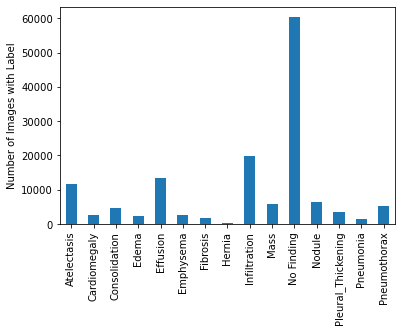

In [5]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')


(array([ 39.,  87., 190., 241., 251., 290., 252.,  67.,  12.,   1.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

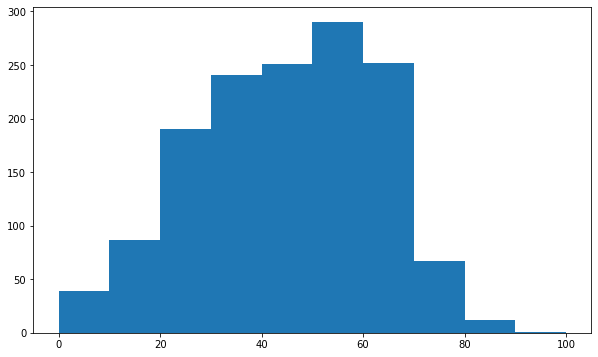

In [6]:
#age distribution of patients with Pneumonia condition
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'][all_xray_df.Pneumonia==1],range=[0, 100.0])


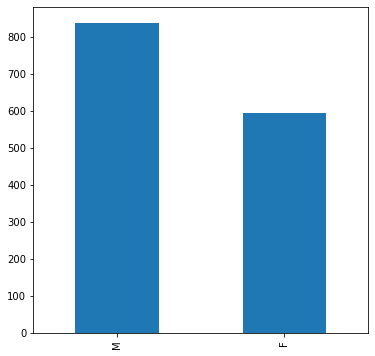

In [7]:
#Gender distribution of patients
plt.figure(figsize=(6,6))
(all_xray_df['Patient Gender'][all_xray_df.Pneumonia==1]).value_counts().plot(kind='bar')

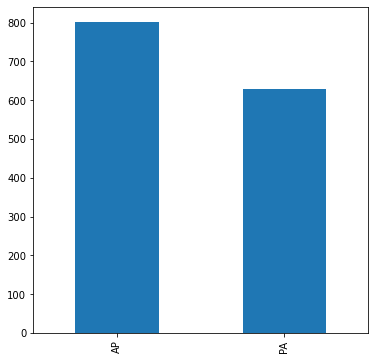

In [8]:
#Position distribution of patients
plt.figure(figsize=(6,6))
(all_xray_df['View Position'][all_xray_df.Pneumonia==1]).value_counts().plot(kind='bar')

In [9]:
#The number of cases including number of pneumonia cases,number of non-pneumonia cases
#age distribution of patients
print("Pneumonia Cases: " + str(len(all_xray_df[all_xray_df.Pneumonia>=1.0])))
print("Non Pneumonia Cases: " + str(len(all_xray_df[all_xray_df.Pneumonia==0.0])))


Pneumonia Cases: 1431
Non Pneumonia Cases: 110689


In [11]:
#Number of disease per patient
all_xray_df["DiseasePerPatient"] = all_xray_df[all_labels].sum(axis=1)
all_xray_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,DiseasePerPatient
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

sample_paths={os.path.basename(x):x for x in glob(os.path.join('/data','images*','*','*.png'))}
sample_df['paths'] = sample_df['Image Index'].map(sample_paths.get)
sample_df.head()

sample_pneumonia = sample_df[sample_df['Finding Labels'].str.contains('Pneumonia')]
sample_nodieases = sample_df[sample_df['Finding Labels'].str.contains('No Finding')]
print(len(sample_pneumonia))


62


In [24]:
def display_intensity(sample):
    colomns =3
    rows=3
    plt.figure(figsize=(20,20))
    for i in range(colomns*rows):
        plt.subplot(rows,colomns,i+1)
        img=plt.imread(sample.iloc[i]['paths'])
        mean_intensity=np.mean(img)
        std_intensity=np.std(img)
        newimg=img.copy()
        newimg=(newimg-mean_intensity)/std_intensity
        plt.hist(newimg.ravel(),bins=256)


In [14]:
def display_XrayImages(sample):
    colomns =3
    rows=3
    fig=plt.figure(figsize=(10, 10))
    for i in range(rows*colomns):
        #fig.add_subplot(len(sample_pneumonia)/colomns+1,colomns,i+1)
        fig.add_subplot(rows,colomns,i+1)
        img=plt.imread(sample.iloc[i]['paths'])
        plt.imshow(img,cmap='gray')
    plt.show()

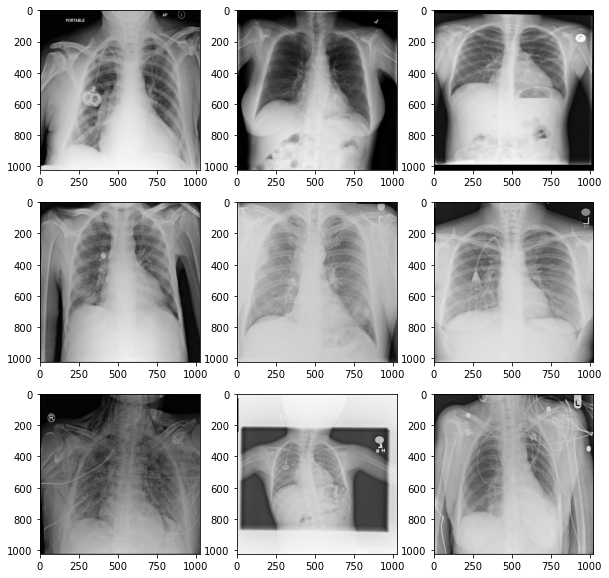

In [15]:
# Pneumonia sample images
display_XrayImages(sample_pneumonia)

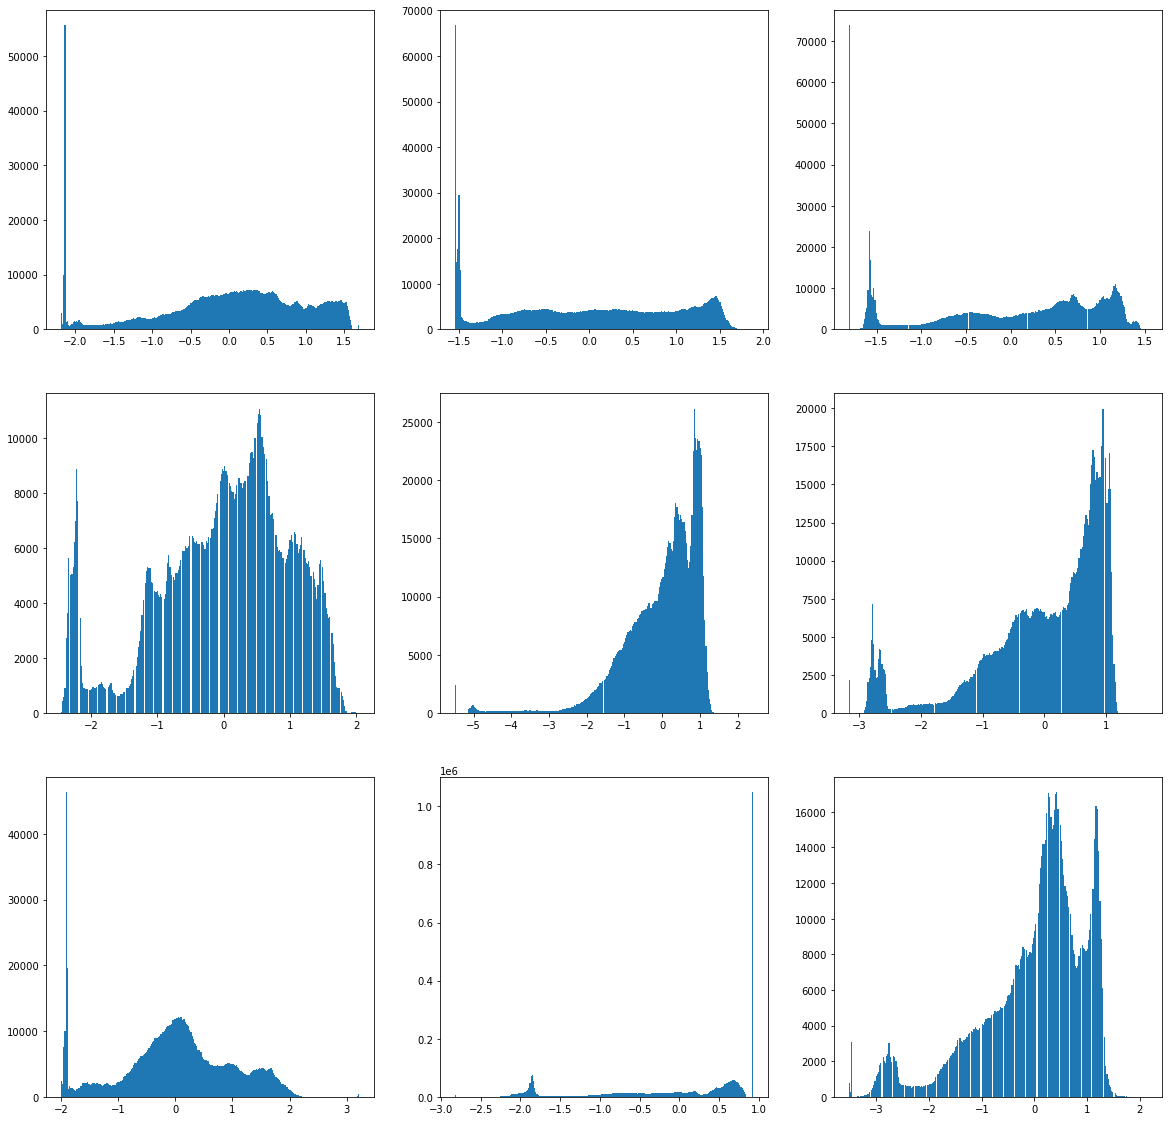

In [25]:
# Pneumonia sample intensity graphs
display_intensity(sample_pneumonia)


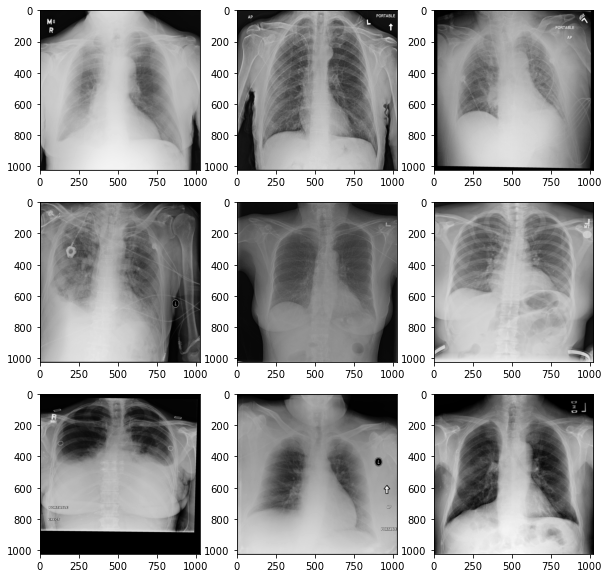

In [17]:
# Non-Pneumonia sample images
display_XrayImages(sample_nodieases)

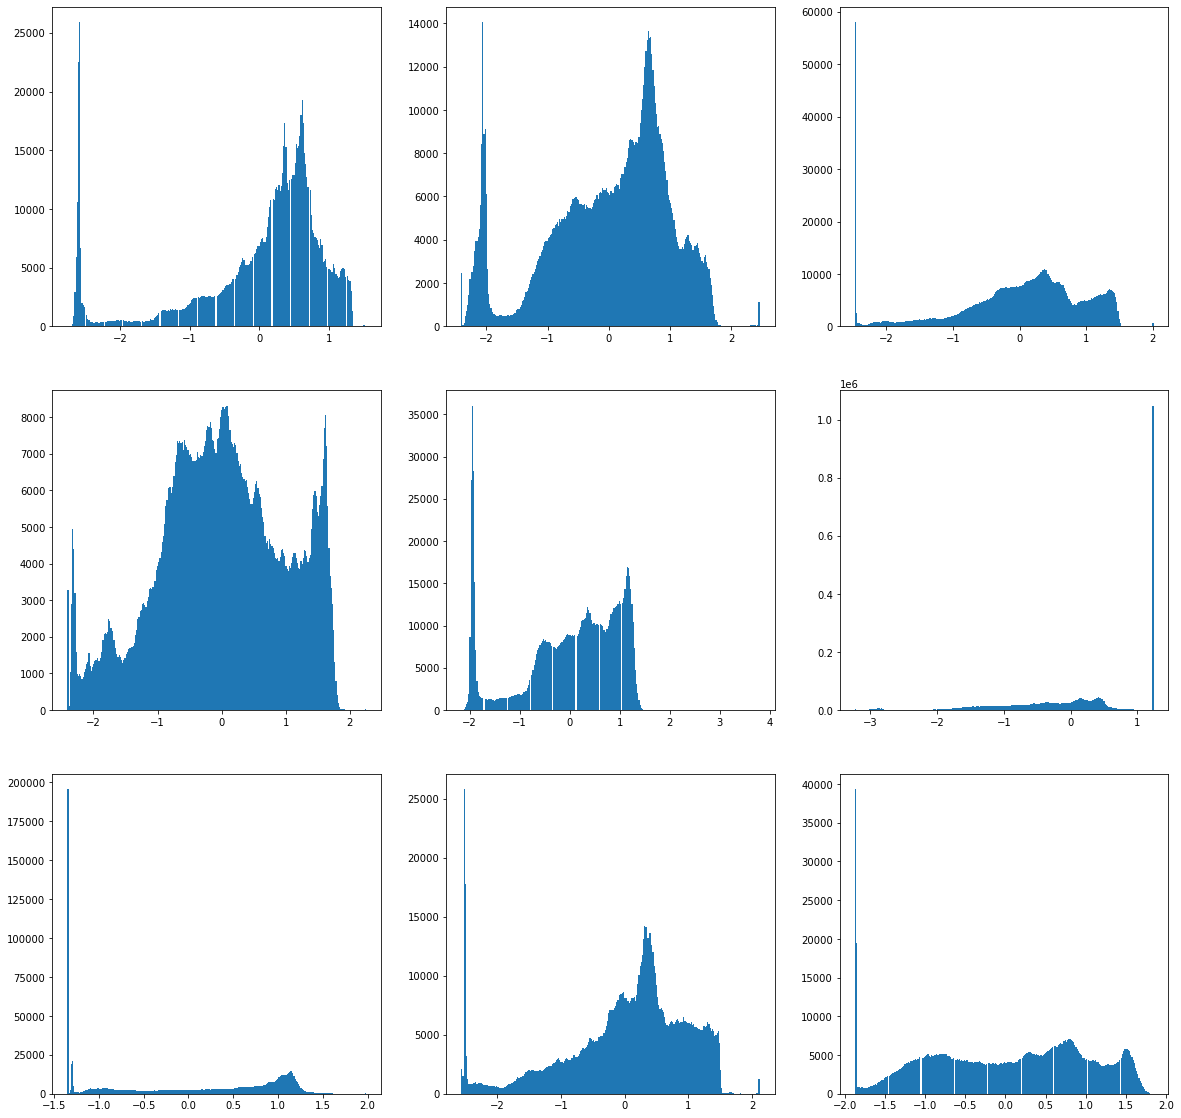

In [18]:
# Non-Pneumonia sample images
display_intensity(sample_nodieases)

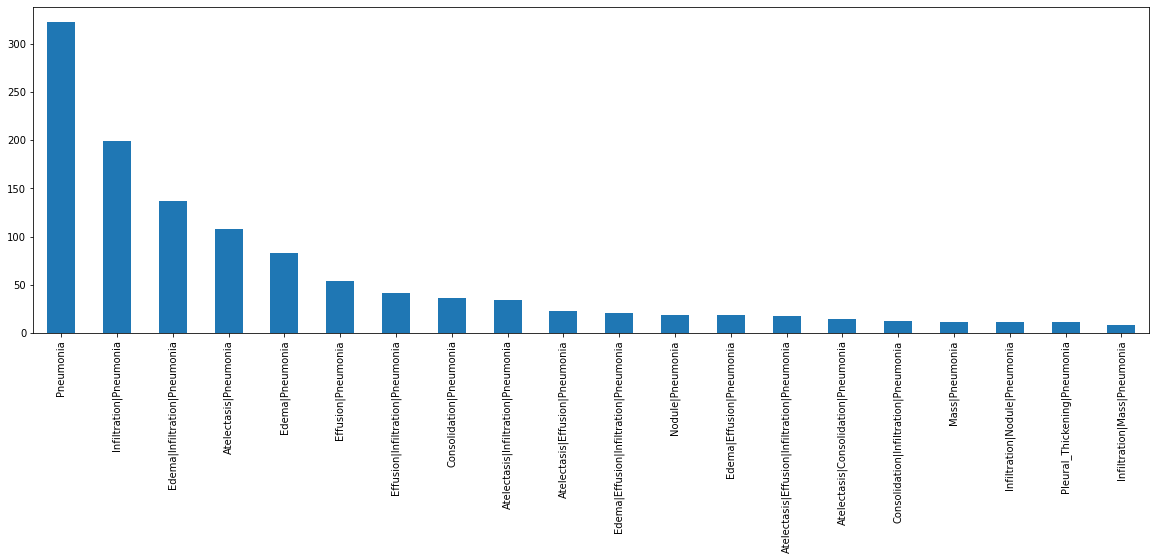

In [19]:
#The distribution of other diseases that are comorbid with pneumonia

plt.figure(figsize=(20,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')

In [20]:
#main conditions that are comorbid with Pneumonia
sample_infiltration = sample_df[sample_df['Finding Labels'].str.contains('Infiltration')]
sample_edema = sample_df[sample_df['Finding Labels'].str.contains('Edema')]
sample_effusion=sample_df[sample_df['Finding Labels'].str.contains('Effusion')]
sample_atelectasis=sample_df[sample_df['Finding Labels'].str.contains('Atelectasis')]



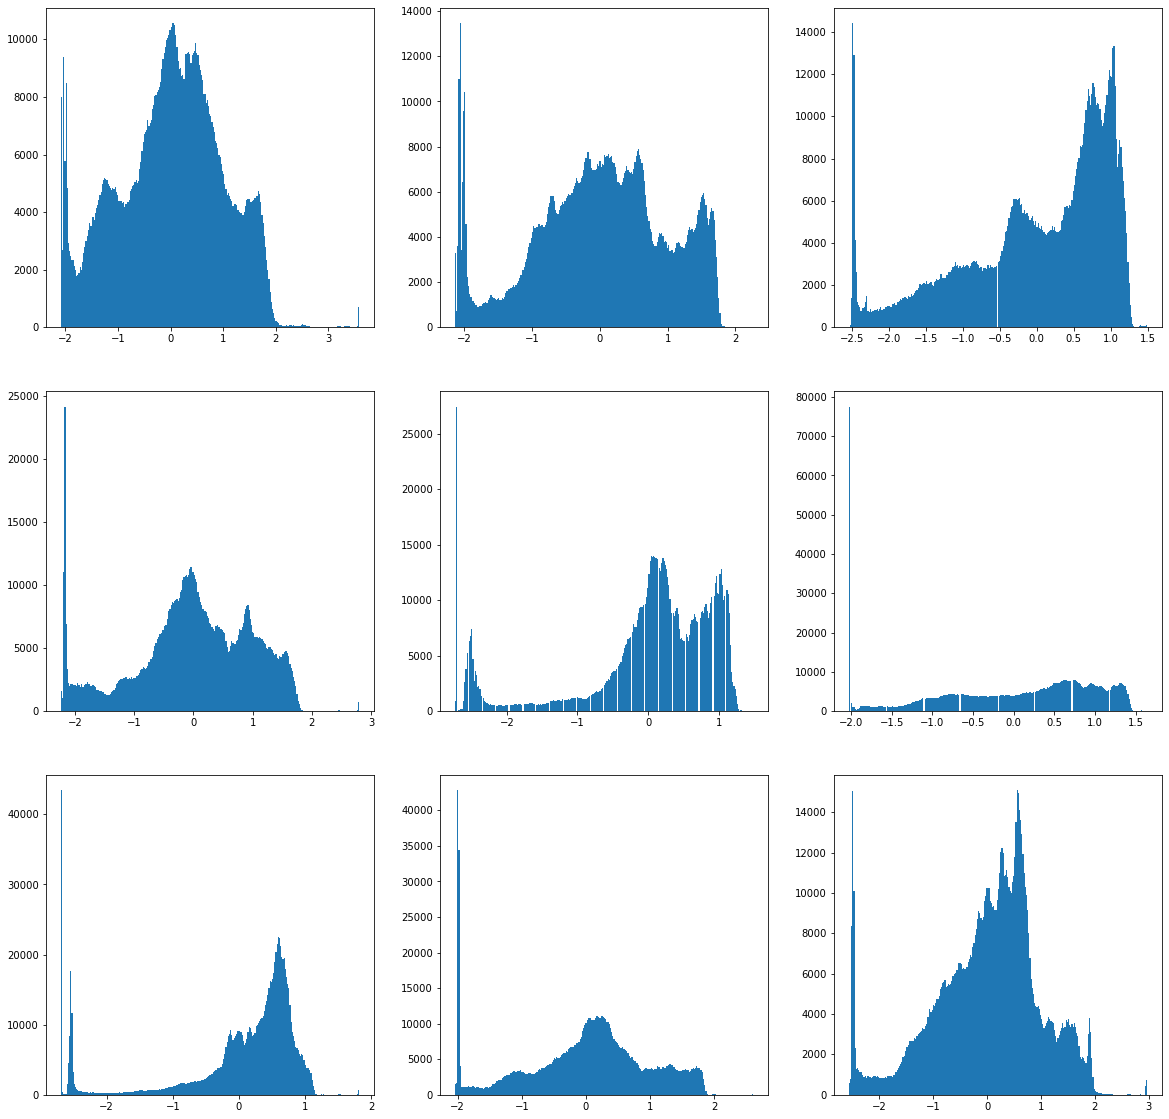

In [21]:
display_intensity(sample_infiltration)

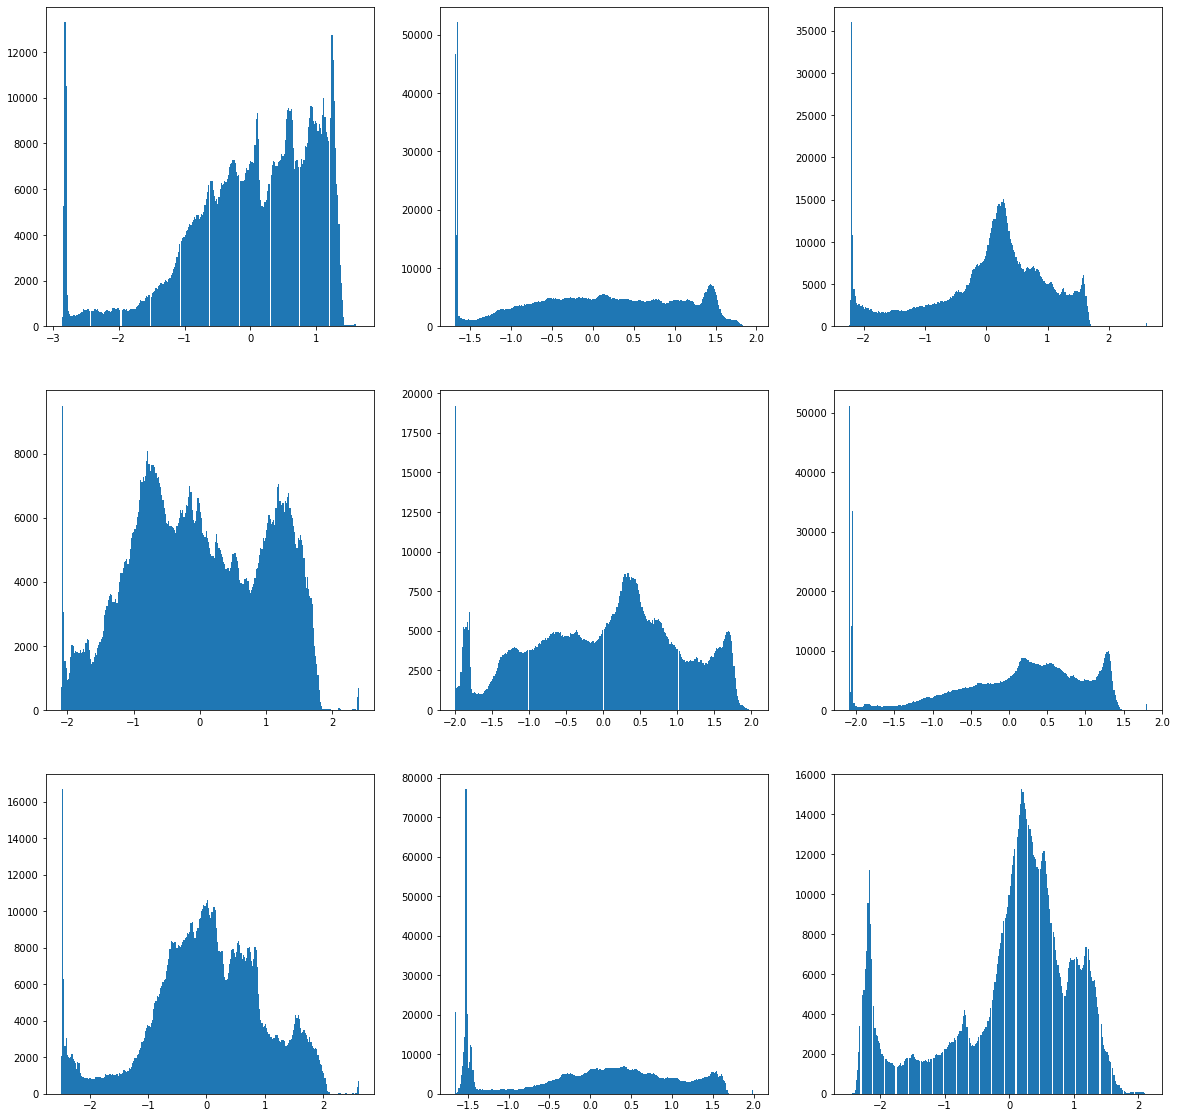

In [22]:
display_intensity(sample_edema)

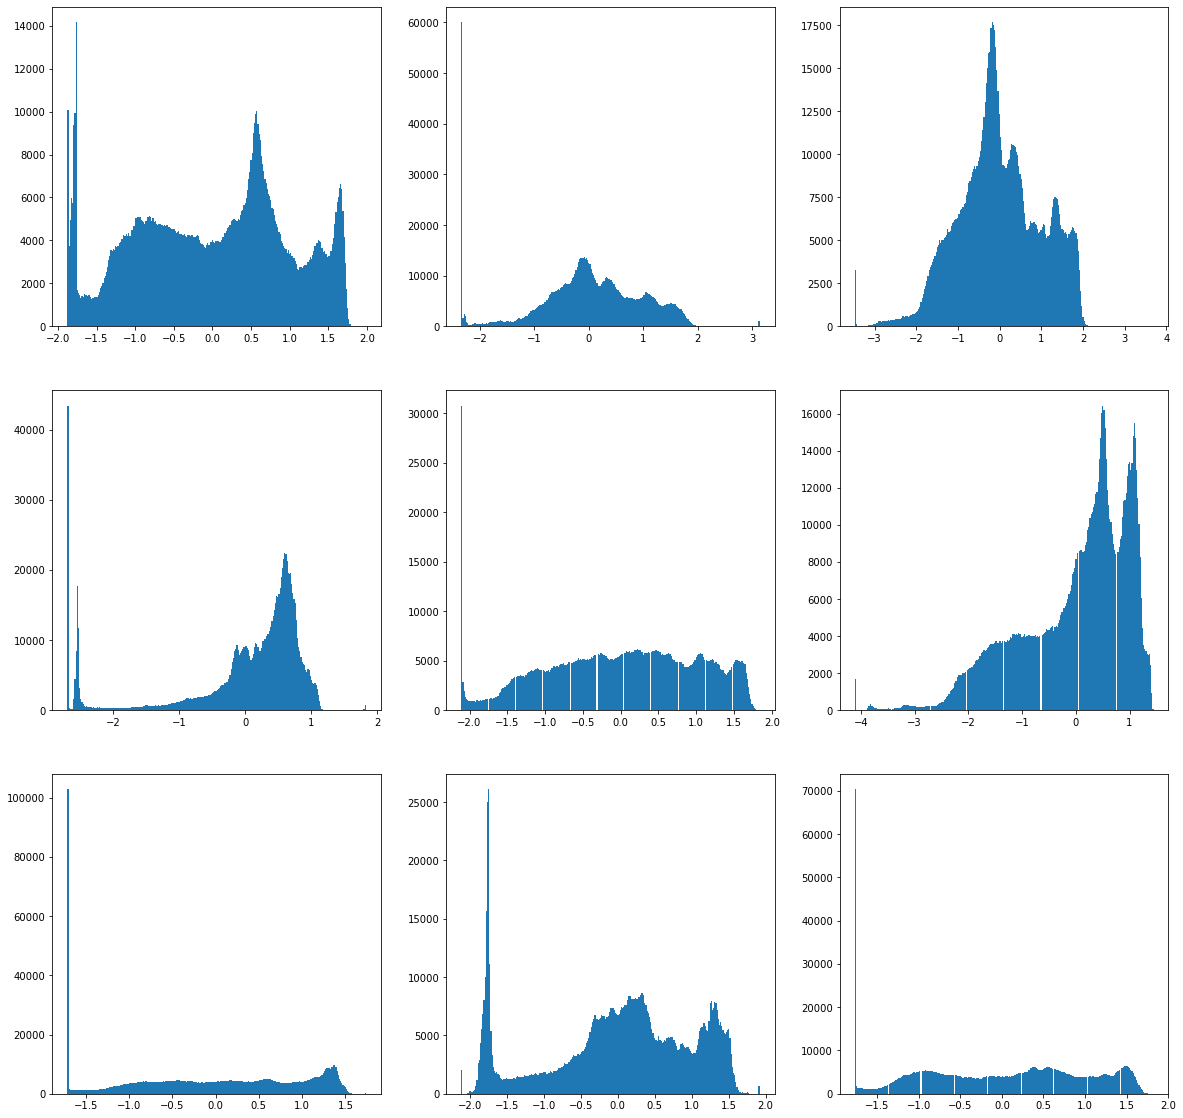

In [23]:
display_intensity(sample_atelectasis)



1) Data Distribution based on Patient Demography - Age,Gender: We have analysed that data based on Gender and Age these are the only details that have been provided to us. As seen in graphs above majority of Pneumonia cases we found are between 20-75 years. There are more Male count (830) then Female count(550) but the difference is not stark. We do not need to split the training data based on gender or Age inorder to have a balanced training data. However we should mention that intended use of algorithm is restricted to patients of age between 20-75 Yrs.

2) The x-ray views taken - AP,PA - We analysed that AP has higher counts(800) then PA(600) however again we do not need to split the training data to create a balance data based on views.

3) The number of cases of Pnumonia: There is a stark difference between Pneumonia and non Pneumonia cases.There are 1431 Pneumonia Cases. Where as there are 110689 Non Pneumonia Cases. So we do need to split the training data inorder to have Non Penumonia cases close to Pneumonia cases in order to have a balanced data set for training.

4) Distribution of other diseases that are comorbid with pneumonia : The most common disease that co-exists with Pneumonia is Infiltration.We can assume that this will be a challenge if we have to identify Infiltration condition from Pneumonia cases, however thats not our current use case.

##Conclusion: 

Number of Pnumonia vs Non-Pnumonia needs to be taken into account while splitting training data. The need to be equal in order to create a balanced training dataset.

'Infiltration','Edema','Effusion' and 'Atelectasis' are pretty close in intensity level to pneumonia.We can include these dieases that are comorbid as well.
 
 P.S. Intensity Level is pretty confusing as some of the "no Pneumonia " images have similiar intensity levels to "Pneumonia" cases.